### Loading Data

In [1]:
with open("./data/text8") as f:
    text = f.read()

In [2]:
text[:1000]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institut

### PreProcessing

In [3]:
import re
from collections import Counter

class TextPreProcessor:
    def __init__(self, text):
        self.text = text.lower()
        #Replacing punctuation with tokens
        self.text = self.text.replace('.',' <PERIOD> ')
        self.text = self.text.replace(',', ' <COMMA> ')
        self.text = self.text.replace('"', ' <QUOTATION_MARK> ')
        self.text = self.text.replace(';', ' <SEMICOLON> ')
        self.text = self.text.replace('!', ' <EXCLAMATION_MARK> ')
        self.text = self.text.replace('?', ' <QUESTION_MARK> ')
        self.text = self.text.replace('(', ' <LEFT_PAREN> ')
        self.text = self.text.replace(')', ' <RIGHT_PAREN> ')
        self.text = self.text.replace('--', ' <HYPHENS> ')
        self.text = self.text.replace('?', ' <QUESTION_MARK> ')
        self.text = self.text.replace(':', ' <COLON> ')
        
        self.words = self.text.split()
        self.word_counts = Counter(self.words)
        
        
    def get_trimmed_words(self, min_word_occ):
        return [word for word in self.words if self.word_counts[word] > min_word_occ]
    
    def create_lookup_tables(self):
        sorted_vocab = sorted(self.word_counts, key=self.word_counts.get, reverse=True)
        
        int_to_vocab = {i:v for i,v in enumerate(sorted_vocab)}
        vocab_to_int = {v:i for i,v in int_to_vocab.items()}

        return vocab_to_int, int_to_vocab
    

In [4]:
text_pre_processor = TextPreProcessor(text)
words = text_pre_processor.get_trimmed_words(5)
vocab_to_int, int_to_vocab = text_pre_processor.create_lookup_tables()

In [5]:
int_words = [vocab_to_int[word] for word in words]

In [6]:
words[:30]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst']

In [7]:
print("Total words in text: {}".format(len(words)))
print("Total unique words in text: {}".format(len(set(words))))

Total words in text: 16680599
Total unique words in text: 63641


In [8]:
list(int_to_vocab.items())[:20]

[(0, 'the'),
 (1, 'of'),
 (2, 'and'),
 (3, 'one'),
 (4, 'in'),
 (5, 'a'),
 (6, 'to'),
 (7, 'zero'),
 (8, 'nine'),
 (9, 'two'),
 (10, 'is'),
 (11, 'as'),
 (12, 'eight'),
 (13, 'for'),
 (14, 's'),
 (15, 'five'),
 (16, 'three'),
 (17, 'was'),
 (18, 'by'),
 (19, 'that')]

In [9]:
list(vocab_to_int.items())[:20]

[('the', 0),
 ('of', 1),
 ('and', 2),
 ('one', 3),
 ('in', 4),
 ('a', 5),
 ('to', 6),
 ('zero', 7),
 ('nine', 8),
 ('two', 9),
 ('is', 10),
 ('as', 11),
 ('eight', 12),
 ('for', 13),
 ('s', 14),
 ('five', 15),
 ('three', 16),
 ('was', 17),
 ('by', 18),
 ('that', 19)]

### Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

In [10]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)

total_count = len(words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1-np.sqrt(threshold/freqs[word]) for word in word_counts}

train_words = [word for word in int_words if random.random() > p_drop[word]]

In [11]:
for i in train_words[:10]:
    print(int_to_vocab[i])

anarchism
originated
term
abuse
early
radicals
diggers
english
the
sans


### Making Batches
With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [12]:
def get_target(words, idx, window_size = 5):
    
    r = np.random.randint(1, window_size+1)
    start = idx - r if idx>=r else 0
    stop = idx + r
    
    return words[start:idx] + words[idx+1:stop+1]

In [13]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=2)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [3, 4, 6, 7]


### Generating Batches
Here's a generator functions that returns batches of input and target data for the model, using the `get_target` functino from above. The idea is that it grabs `batch_size` worods fromo a words list. Then for each of those batches, it gets the target words in a window

In [14]:
def get_batches(words, batch_size, window_size = 5):
    
    n_batches = len(words) // batch_size
    
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [],[]
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x,y
        

In [15]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


### Validation

We need a function to help us observe the model as it learns. We'll use cosine similarity to measure closness of words:

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each vector $\vec{b}$ in the embedding table. This way, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.


In [16]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device = 'cpu'):
    '''
        Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module
    '''
    # Here, we're calculating the cosine similarity between some random words and
    #our embedding vectors. With the similarities, we can look at waht words are 
    # close to our random words
    
    # sim (a.b) / |a||b|
    
    embed_vectors = embedding.weight
    
    #magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from ranges (0, window) and (1000, 1000+window)
    # Lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, \
                               random.sample(range(1000, 1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
    
    return valid_examples, similarities

    

## Skip-Gram Model

---
### Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

In [17]:
import torch
from torch import nn
import torch.optim as optim

In [18]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        #embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        #initializing embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1,1)
        self.out_embed.weight.data.uniform_(-1,1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """
        Generate noise vectors with shape (batch_size, n_samples, n_embed)
        """
        
        if self.noise_dist is None:
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        noise_words = torch.multinomial(noise_dist, batch_size*n_samples, replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors
        

In [19]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

### Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGram(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 25

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/25
Loss:  6.714881420135498
be | one, number, in, picta, doctorates
by | comnenus, caesar, desperate, of, a
from | an, neoconservatism, of, kevin, entrusted
united | have, judgment, munch, angle, publicized
its | blues, toxicity, recrystallized, tobago, pareudiastes
all | monthly, reverdy, grapefruits, experiments, ellipsoids
d | potomac, much, ferment, location, rayok
zero | two, nine, fights, chief, of
question | nominations, vacuums, ortelius, polarized, thecommonreview
older | cois, fartknocker, rufifacies, thomond, allose
mainly | etorri, apparently, oxygen, favour, irritate
resources | autobiography, collaborators, due, foulenough, rca
units | dio, brihadaranyaka, athlete, inactivation, sock
road | galloping, park, studio, miami, tourism
event | morrisette, boulevards, rioth, hitchcocks, boilers
engine | firmicutes, hypoxidaceae, bsar, dwarfish, ius
...

Epoch: 1/25
Loss:  5.272209644317627
more | the, a, are, in, lighthouse
most | and, the, in, for, to
can | the, one, i

Epoch: 3/25
Loss:  2.679097890853882
his | he, him, brother, was, son
see | of, also, the, five, article
often | or, tend, addition, wide, can
history | links, references, list, encyclopedia, external
he | his, him, himself, had, brother
will | that, should, you, me, a
with | a, in, and, as, the
for | a, also, set, and, or
derived | latin, derivation, meaning, name, languages
additional | instead, file, example, standard, for
running | run, runs, coach, game, introduced
prince | king, emperor, duke, queen, reign
instance | example, substance, valid, be, define
recorded | rock, songs, band, album, music
operations | operation, group, civilian, addition, supplies
scale | scales, relative, instruments, tone, markedly
...

Epoch: 3/25
Loss:  2.4551072120666504
so | can, to, too, could, they
between | from, the, an, are, of
were | was, during, destroyed, armies, had
was | his, after, had, the, who
their | the, they, a, and, more
used | use, commonly, or, are, common
during | period, to, was

Epoch: 5/25
Loss:  2.242072343826294
new | york, seven, company, edition, one
been | have, was, to, the, a
than | usually, are, to, it, more
there | have, the, many, are, in
th | century, nd, rd, centuries, st
after | was, he, last, had, during
s | by, nine, the, and, was
over | from, to, years, in, the
articles | org, article, http, links, publications
http | www, com, html, htm, org
notes | note, diatonic, isbn, tuning, chromatic
engine | engines, powered, combustion, diesel, jet
derived | modern, meaning, name, derivation, word
ocean | atlantic, pacific, islands, sea, mountains
magazine | monthly, magazines, fan, published, video
freedom | liberty, political, anti, equality, freedoms
...

Epoch: 5/25
Loss:  2.5195043087005615
are | different, or, usually, can, have
some | many, it, not, to, such
first | the, in, for, second, one
by | and, in, while, the, of
these | generally, are, or, many, from
an | in, the, for, a, of
its | from, the, has, is, which
it | be, not, to, is, a
know | 

Epoch: 7/25
Loss:  2.124408483505249
all | are, have, only, some, and
or | are, as, often, typically, be
after | was, in, at, by, nine
i | want, me, you, t, we
that | is, be, not, to, have
their | they, have, but, and, were
as | the, of, and, to, or
however | but, not, have, that, some
stage | film, phase, having, minutes, theatre
centre | metropolitan, located, town, centres, situated
active | passive, activities, other, low, helping
road | roads, railway, routes, park, highway
running | run, slower, line, backs, ran
versions | windows, version, features, configuration, software
proposed | proposals, debate, link, propose, established
lived | half, father, died, was, grandfather
...

Epoch: 7/25
Loss:  2.2744295597076416
up | the, in, a, by, while
and | in, as, a, the, of
be | can, that, might, to, is
called | when, is, as, a, the
the | of, in, a, for, as
been | by, has, was, in, had
but | this, with, to, from, as
system | systems, operating, which, used, of
institute | university, co

Epoch: 9/25
Loss:  2.0929183959960938
used | use, uses, describe, commonly, similar
which | a, for, called, an, the
eight | one, six, four, two, three
more | than, most, is, these, and
if | any, be, must, whether, it
years | last, period, year, after, remaining
see | also, links, list, references, external
are | or, is, different, these, be
alternative | complementary, medicine, list, advocates, methods
brother | son, sons, his, throne, daughter
something | know, somehow, idea, say, useless
nobel | prize, laureate, physicist, recipient, chemist
taking | up, in, he, proceed, control
centre | located, largest, shopping, situated, city
applied | ethics, also, classified, is, type
placed | wooden, were, once, belonging, constructed
...

Epoch: 9/25
Loss:  2.2824854850769043
between | from, are, separated, and, within
than | more, are, is, different, to
history | references, links, historical, external, modern
five | three, one, four, zero, two
during | in, was, period, lasted, after
has | 

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

NameError: name 'model' is not defined

In [5]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

NameError: name 'embeddings' is not defined

NameError: name 'embed_tsne' is not defined

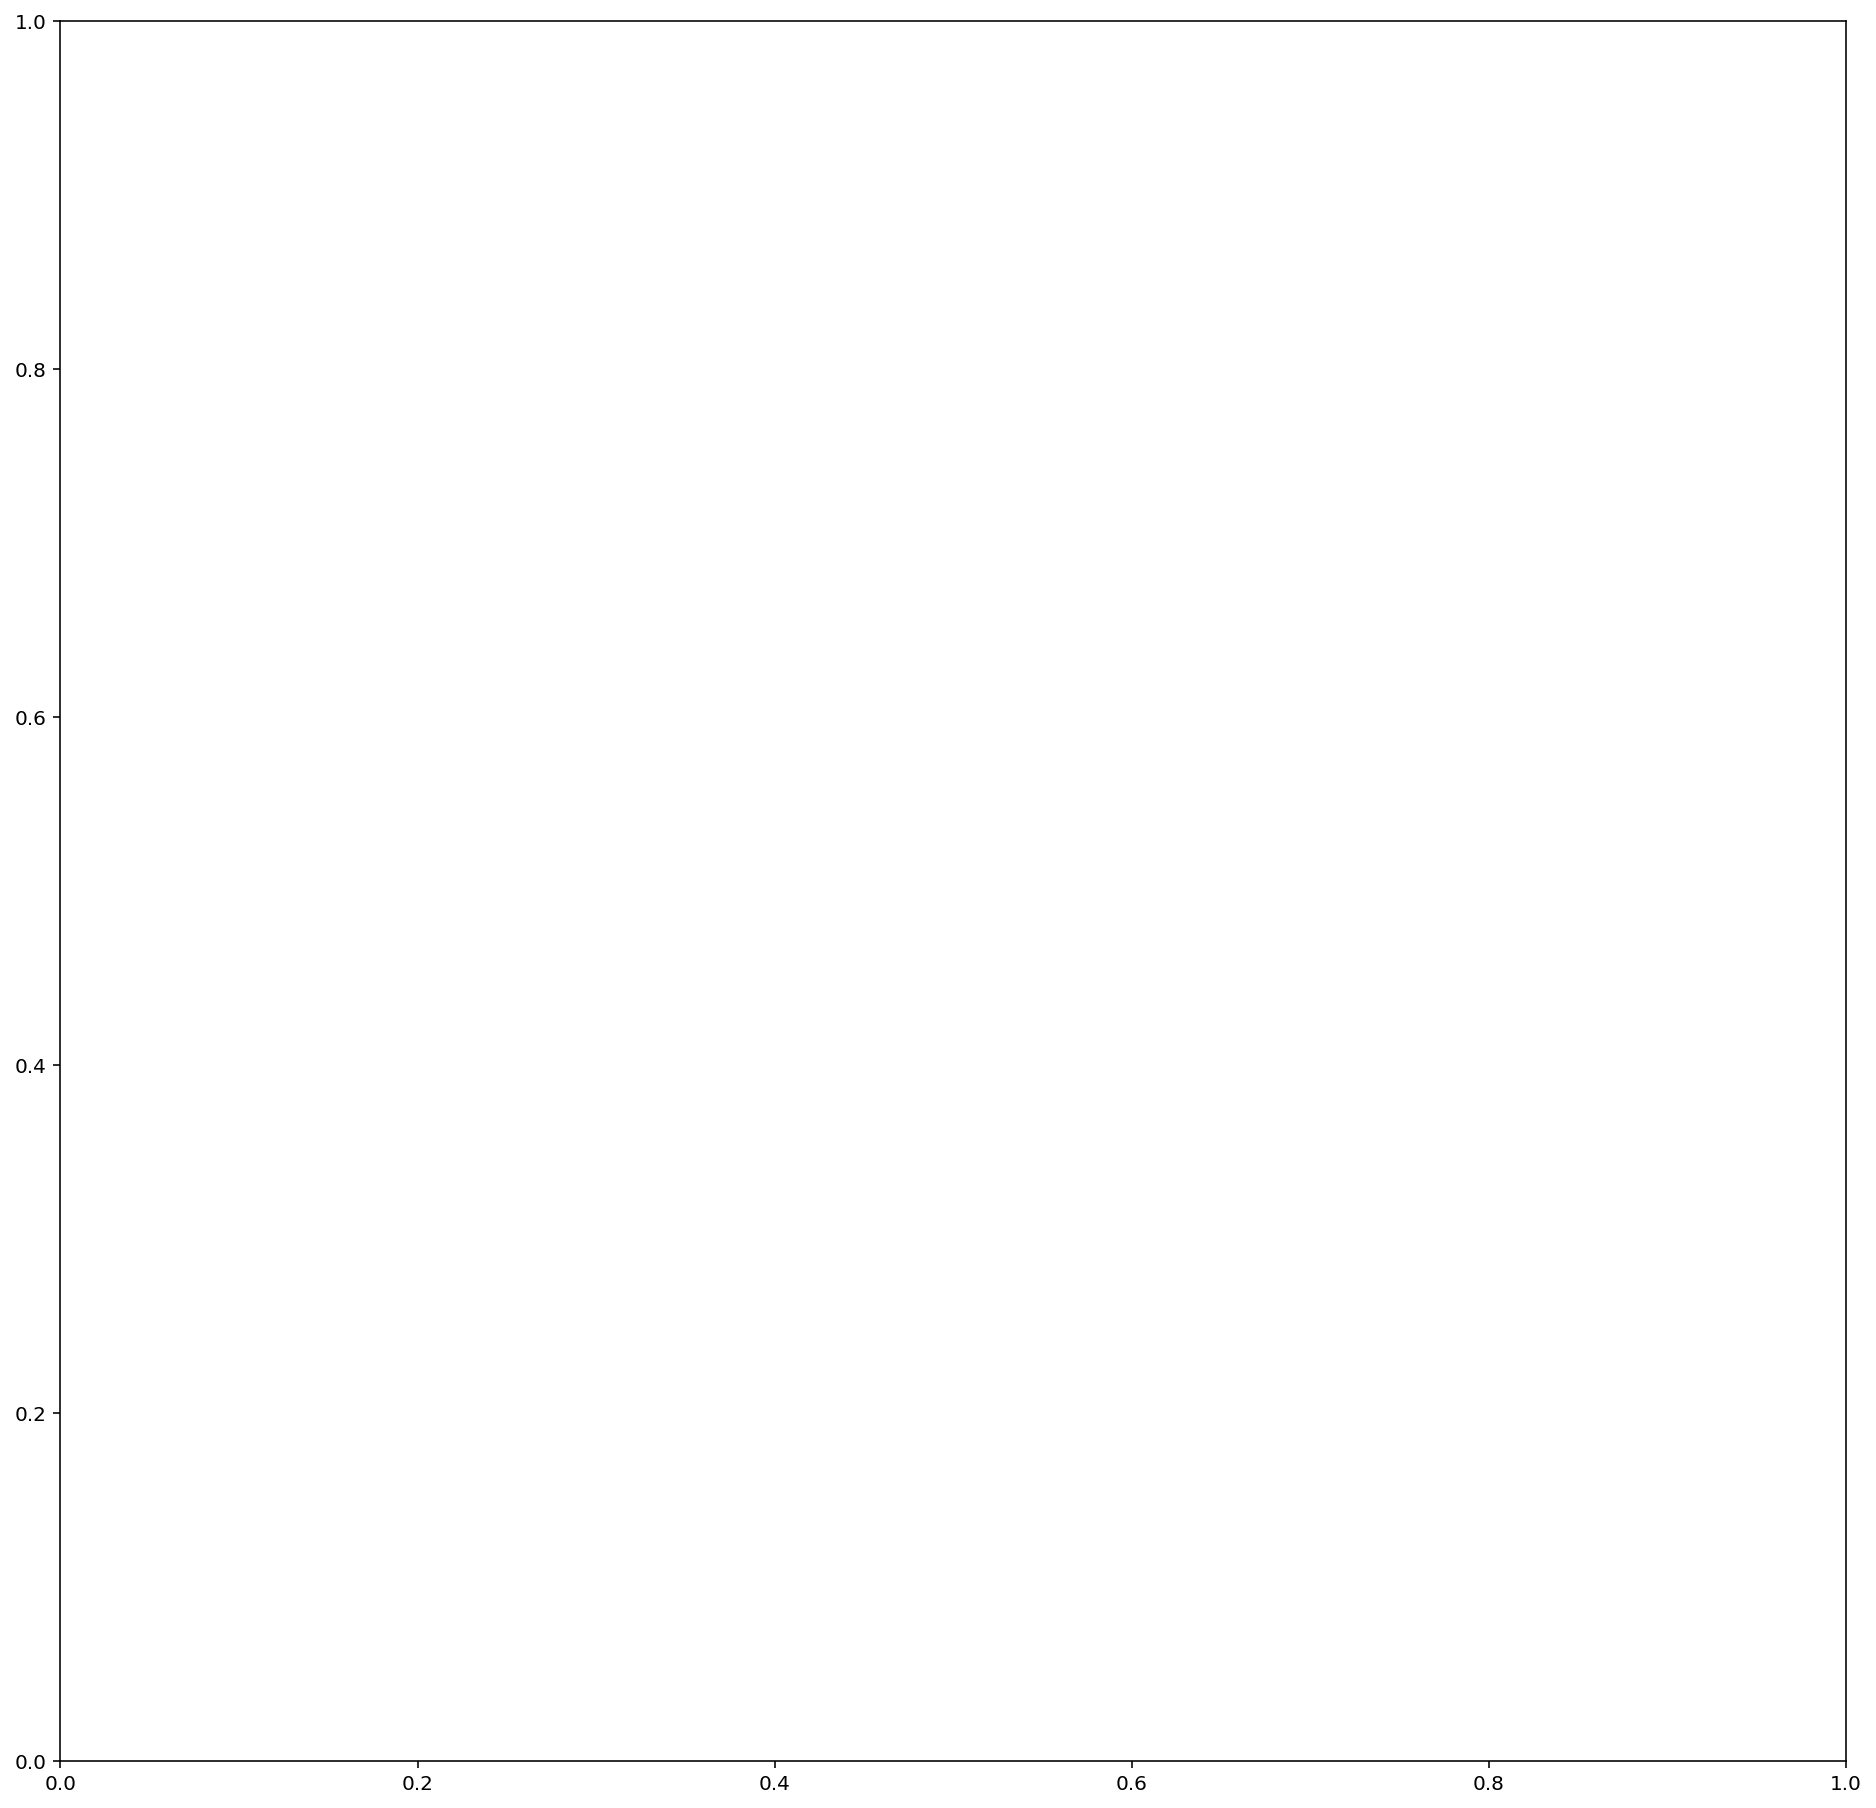

In [6]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)